In [1]:
import os
import sys
from datetime import datetime
import keras

import argparse
import numpy as np
import pandas as pd
# import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline


from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam, SGD, Adamax


from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight


from model import build_model
from func import * 

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# path = '/home/katieyth/gynecology/model_save/management/management_181225153555'
path = '/home/katieyth/gynecology/model_save/UA/UA_181225153657'
# path = '/home/katieyth/gynecology/model_save/variability/variability_181225153624'
# path = '/home/katieyth/gynecology/model_save/deceleration/deceleration_181225153736'





In [3]:
#### parser
parser = argparse.ArgumentParser()
parser.add_argument('-d' ,'--data', type=str, default='/home/katieyth/gynecology/data/data_cmu_ctu_Ntest.csv', help='data')
parser.add_argument('-s' ,'--model_save', type=str, default='/home/katieyth/gynecology/model_save/', help='model save path')
parser.add_argument('-wb','--weight_balance', type=int, default=1, help='whether weight balancing or not')
parser.add_argument('-y' ,'--target', type=str, default='deceleration', help='prediction target')
# variability	UA	 deceleration management

parser.add_argument('-g' ,'--gpu_id', type=str, default='6', help='GPU ID')
parser.add_argument('-rs' ,'--random_state', type=int, default=13, help='random state when train_test_split')
parser.add_argument('-fn' ,'--summary_file', type=str, default=None, help='summary filename')

FLAG = parser.parse_args([])

In [4]:
print("===== train =====")
os.environ['CUDA_VISIBLE_DEVICES'] = FLAG.gpu_id
d = pd.read_csv(os.path.join(FLAG.data))
# d = d[myutils.get_n_zeros(np.array(d[[k for k in d.columns if 'b-' in k]], dtype=np.float)) <= FLAG.acceptable_zeros_threshold]

# if FLAG.force_binary : 
#     d[d[FLAG.target]>1] = 1

n_classes = len(set(d[FLAG.target]))

# replace 0 (no readings) with np.nan for later substitution
for k in d.columns:
    if 'b-' in k or 'm-' in k:
        print(k, end='\r')
        d.loc[d[k]==0, k] = np.nan

train_d,valid_d = train_test_split(d, test_size=0.3, random_state=FLAG.random_state, stratify =d[FLAG.target])

# interpolate missing values
train_db = np.array(train_d[[k for k in train_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
train_dm = np.array(train_d[[k for k in train_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

valid_db = np.array(valid_d[[k for k in valid_d.columns if 'b-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)
valid_dm = np.array(valid_d[[k for k in valid_d.columns if 'm-' in k]].interpolate(limit_direction='both', axis=1), dtype=np.float)

# combine signals from baby and mom
Xtrain = np.stack([train_db, train_dm], axis=2)
Xvalid = np.stack([valid_db, valid_dm], axis=2)

# convert labels to one-hot encodings
Ytrain = keras.utils.to_categorical(np.array(train_d[FLAG.target]), num_classes=n_classes)
Yvalid = keras.utils.to_categorical(np.array(valid_d[FLAG.target]), num_classes=n_classes)

# weight balancing or not
if FLAG.weight_balance:

    y_integers = np.argmax(Ytrain, axis=1)
    d_class_weight = compute_class_weight('balanced', np.unique(y_integers), y_integers)
    class_weight = dict(enumerate(d_class_weight))
    print('class weight: {0}'.format(class_weight))
else:
    class_weight = dict()
    for i in range(n_classes):
        class_weight[i] = 1

Xtest, Ytest, Wtest =data_preprocess_test(Xvalid, Yvalid, class_weight = class_weight)
#print(Wtest)
# print(Xtest.shape)
# print(Xtest[0:5])
# class weight: {0: 0.5892575039494471, 1: 1.0626780626780628, 2: 2.762962962962963}

===== train =====


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


class weight: {0: 0.9053398058252428, 1: 2.8257575757575757, 2: 0.4036796536796537, 3: 15.541666666666666}


In [5]:
# evaluate by trained model
trained_model = load_model(os.path.join(path,'model.h5'))
Pred = trained_model.predict(Xtest)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


accuracy :  0.1242
recall-0 : 0.1333
recall-1 : 1.0
recall-2 : 0.0
recall-3 : 0.0
precision-0: 0.5455
precision-1: 0.0933
precision-2: nan
precision-3: nan
Confusion matrix, without normalization
[[ 6 39  0  0]
 [ 0 14  0  0]
 [ 5 94  0  0]
 [ 0  3  0  0]]


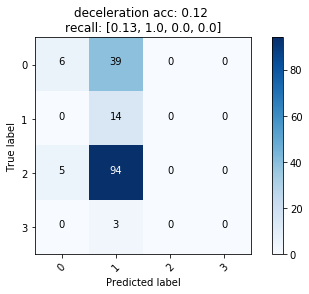

In [6]:
# evaluate validation set
ypred_aug = np.argmax(Pred , axis=1)
ytest_aug = np.argmax(Ytest, axis=1)
cfm = confusion_matrix(y_pred=ypred_aug, y_true=ytest_aug)

recall = np.diag(cfm) / np.sum(cfm, axis=1)
precision = np.diag(cfm) / np.sum(cfm, axis=0)
val_accu = accuracy_score(y_pred=ypred_aug, y_true=ytest_aug)

print('accuracy : ', round(val_accu,4))
for i in range(n_classes):
    print('recall-{0} : {1}'.format(i, round(recall[i],4)))
for i in range(n_classes):
    print('precision-{0}: {1}'.format(i, round(precision[i],4)))
    
plt.figure()
rcl = [round(recall[i],2) for i in range(n_classes)]
plot_confusion_matrix(cfm, classes=np.arange(n_classes),
                      title='%s acc: %.2f \nrecall: %s' %(FLAG.target, val_accu, rcl),
                     )#save_dir=path)

min val_loss 1.658712729904222 at epoch 999


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


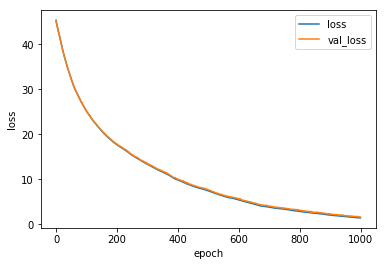

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


max val_accu 0.9627329192546584 at epoch 757


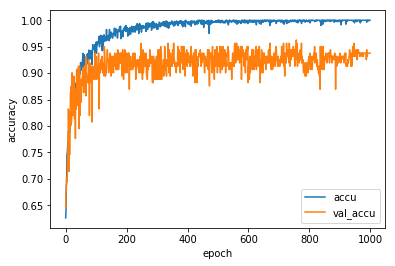

In [7]:
# plot learning curve
plot_keras_csv_logger(os.path.join(path,'training.log'),  accuracy=True) # save_dir=path,

# feature analysis

In [8]:
pred_hd_l = np.argmax(Pred, axis=1)
valid_d.reset_index(inplace=True)
pred_dataset = valid_d['ID']

In [9]:
cmu_id = [i for i, e in enumerate(valid_d['ID']) if 'CMU_' in e]
ctu_id = [i for i, e in enumerate(valid_d['ID']) if 'CTU_' in e]

In [10]:
features = trained_model.get_layer('global_average_pooling1d_1')
extractor = Model(inputs=trained_model.input, outputs=features.output)
Fout = extractor.predict(x=Xtest)

In [11]:
O_X = valid_d[FLAG.target] == pred_hd_l
print('Wrong Prediction:', len(O_X)-sum(O_X))
print('Acc:', sum(O_X)/len(O_X))
# O_X[O_X==1] = 'gray'
# O_X[O_X==0] = 'red'

Wrong Prediction: 141
Acc: 0.12422360248447205


In [12]:
def get_color_map(ref_list):
    color_map=[]
    for i in ref_list:
        if i ==0:
            color_map.append('orange')
        elif i==1:
            color_map.append('blue')
        elif i==2:
            color_map.append('green')
        elif i==3:
            color_map.append('red')
    color_map = np.array(color_map)
    return color_map

In [13]:
def get_color_map_OX(ref_list):
    color_map=[]
    for i in ref_list:
        if i ==0:
            color_map.append('red')
        elif i==1:
            color_map.append('gray')
    color_map = np.array(color_map)
    return color_map

## PCA

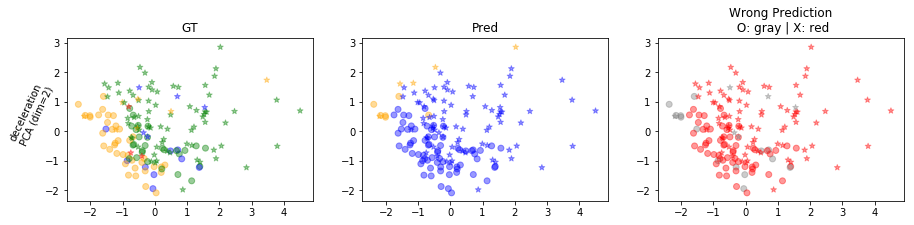

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(Fout)


fig = plt.figure(figsize=(15,3))
plt.subplot('13%s' % (1))
color_map = get_color_map(valid_d[FLAG.target])
plt.scatter(pca_emb[cmu_id,0], pca_emb[cmu_id,1], c = color_map[cmu_id], marker='o', cmap='coolwarm', alpha=0.4)
plt.scatter(pca_emb[ctu_id,0], pca_emb[ctu_id,1], c = color_map[ctu_id], marker='*', cmap='coolwarm', alpha=0.4)
plt.ylabel('%s\n PCA (dim=2)' %(FLAG.target), rotation=65)
plt.title('GT')

plt.subplot('13%s' % (2))
color_map = get_color_map(pred_hd_l)
plt.scatter(pca_emb[cmu_id,0], pca_emb[cmu_id,1], c = color_map[cmu_id], marker='o', cmap='cool', alpha=0.4)
plt.scatter(pca_emb[ctu_id,0], pca_emb[ctu_id,1], c = color_map[ctu_id], marker='*', cmap='cool', alpha=0.4)
plt.title('Pred')

plt.subplot('13%s' % (3))
color_map = get_color_map_OX(O_X)
plt.scatter(pca_emb[cmu_id,0], pca_emb[cmu_id,1], c = color_map[cmu_id], marker='o', alpha=0.4)
plt.scatter(pca_emb[ctu_id,0], pca_emb[ctu_id,1], c = color_map[ctu_id], marker='*', alpha=0.4)
plt.title('Wrong Prediction\n O: gray | X: red')
# plt.show()

# # check_dir('./plot/feature_analysis/')
fig.savefig(os.path.join(path, 'F_analysis_pca_%s.png') % (FLAG.target), dpi=100, format='png',bbox_inches='tight' )

## TSNE

In [15]:
# from sklearn.manifold import TSNE

# tsne = TSNE(n_components=2, perplexity=50)
# tsne_emb = tsne.fit_transform(Fout)

# fig = plt.figure(figsize=(15,3))
# plt.subplot('13%s' % (1))
# color_map = get_color_map(valid_d[FLAG.target])
# plt.scatter(tsne_emb[cmu_id,0], tsne_emb[cmu_id,1], c = color_map[cmu_id], marker='o', cmap='coolwarm', alpha=0.4)
# plt.scatter(tsne_emb[ctu_id,0], tsne_emb[ctu_id,1], c = color_map[ctu_id], marker='*', cmap='coolwarm', alpha=0.4)
# plt.ylabel('%s\n TSNE (dim=2)' %(FLAG.target), rotation=65)
# plt.title('GT')

# plt.subplot('13%s' % (2))
# color_map = get_color_map(pred_hd_l)
# plt.scatter(tsne_emb[cmu_id,0], tsne_emb[cmu_id,1], c = color_map[cmu_id], marker='o', cmap='cool', alpha=0.4)
# plt.scatter(tsne_emb[ctu_id,0], tsne_emb[ctu_id,1], c = color_map[ctu_id], marker='*', cmap='cool', alpha=0.4)
# plt.title('Pred')

# plt.subplot('13%s' % (3))
# color_map = get_color_map_OX(O_X)
# plt.scatter(tsne_emb[cmu_id,0], tsne_emb[cmu_id,1], c = color_map[cmu_id], marker='o', alpha=0.4)
# plt.scatter(tsne_emb[ctu_id,0], tsne_emb[ctu_id,1], c = color_map[ctu_id], marker='*', alpha=0.4)
# plt.title('Wrong Prediction\n O: gray | X: red')
# # plt.show()

# # # check_dir('./plot/feature_analysis/')
# fig.savefig(os.path.join(path, 'F_analysis_tsne_%s.png') % (FLAG.target), dpi=100, format='png',bbox_inches='tight' )

# SVM

In [16]:
# Fout_train = extractor.predict(x=Xtrain)
# pca_emb_train = pca.fit_transform(Fout_train)
# Ytrain_N1hot = np.argmax(Ytrain,axis=1)
# Ytest_N1hot = np.argmax(Ytest,axis=1)

# from sklearn.svm import SVC
# svc = SVC(kernel='rbf', verbose= True, gamma = 1e-1)
# svc.fit(Fout_train, Ytrain_N1hot)

# svc_pred = svc.predict(Fout)

# # from mlxtend.plotting import plot_decision_regions
# # plot_decision_regions(X=pca_emb_train, y=Ytrain_N1hot, clf=svc)

# # from mlxtend.plotting import plot_decision_regions
# # plot_decision_regions(X=pca_emb, y=Ytest_N1hot, clf=svc)

# # evaluate validation set
# cfm = confusion_matrix(y_pred=svc_pred, y_true=Ytest_N1hot)

# recall = np.diag(cfm) / np.sum(cfm, axis=1)
# precision = np.diag(cfm) / np.sum(cfm, axis=0)
# val_accu = accuracy_score(y_pred=svc_pred, y_true=Ytest_N1hot)

# print('accuracy : ', round(val_accu,4))
# for i in range(n_classes):
#     print('recall-{0} : {1}'.format(i, round(recall[i],4)))
# for i in range(n_classes):
#     print('precision-{0}: {1}'.format(i, round(precision[i],4)))
    
# plt.figure()
# rcl = [round(recall[i],2) for i in range(n_classes)]
# plot_confusion_matrix(cfm, classes=np.arange(n_classes),
#                       title='%s acc: %.2f \nrecall: %s' %(FLAG.target, val_accu, rcl),
#                      )#save_dir=path)